In [38]:
import pandas
from ast import literal_eval
import theano.tensor as T
import numpy as np
import pymc3 as pm
from functools import reduce

df = pandas.read_csv('./processed/segment_8.csv')
for col in df.columns:
    df.loc[:,col] = df.loc[:,col].apply(lambda x: literal_eval(x))

sigmaBG = 20;
sigmaIns = 0.1;
sigmaCarbs = 5;

absorptionTimeIns = 3;
absorptionTimeCarbs = 3;

nSeg = len(df['Basal'][0])
nSeq = len(df['Basal'])

basal = [ [df['Basal'][i][j] for i in range(nSeq)]
         for j in range(nSeg) ]
smbg  = [ [df['MeasBG'][i][j] for i in range(nSeq)]
         for j in range(nSeg) ]
newCarbs = [ [df['NewCarbs'][i][j] for i in range(nSeq)]
         for j in range(nSeg) ]
newInsulin = [ [df['NewInsulin'][i][j] for i in range(nSeq)]
         for j in range(nSeg) ]
delT = [ [df['delT'][i][j] for i in range(nSeq)]
         for j in range(nSeg) ]

# TODO: pull settings from common source
nBins = len(df['NewCarbs'][0][0])
insActCurve = np.multiply(range(0, nBins), 1./(nBins-1)) # TODO: realistic curves, possibly allow scaling
carbActCurve = np.multiply(range(0, nBins), 1./(nBins-1)) # TODO: realistic curves, possibly allow scaling

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    
    # TODO: realistic priors
    M = pm.Normal('Basal', mu=3, sd=2) # Prior on basal metabolism
    CF = pm.Normal('CF', mu=250, sd=50) # Prior on correction factor
    CR = pm.Normal('CR', mu=40, sd=15) # Prior on correction factor
    
    # TODO: compute I & F vectors
    # TODO: add impact of insulin on board
    # TODO: add impact of carbs on board
    
    glus = []
    glus.append(pm.Normal('glucose0', mu=120, sd=20, observed=smbg[0])) # TODO: use mean value here
    for i in range(nSeg-1):
        # TODO: make distribution geometric
        # Calculate predicted next glucose value, based on...
        glus.append(pm.Normal('glucose' + str(i+1), 
                              mu = smbg[i] + # Last value
                                   -1 * np.dot(newInsulin[i], insActCurve) * CF + # Newly-added insulin
                                   np.dot(newCarbs[i], carbActCurve) * CF / CR + # Newly-added carbs
                                   (M - basal[i]) * delT[i]/24 * CF, # Basal/metabolism mismatch
                              sd=20, 
                              observed=smbg[i+1]))

    likelihood = reduce(lambda x, y: x * y, glus)

    # Inference!
    trace = pm.sample(6000, tune=2000, progressbar=True) # draw posterior samples using NUTS sampling
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [CR, CF, Basal]
100%|██████████| 8000/8000 [00:12<00:00, 649.83it/s]


<Figure size 504x504 with 0 Axes>

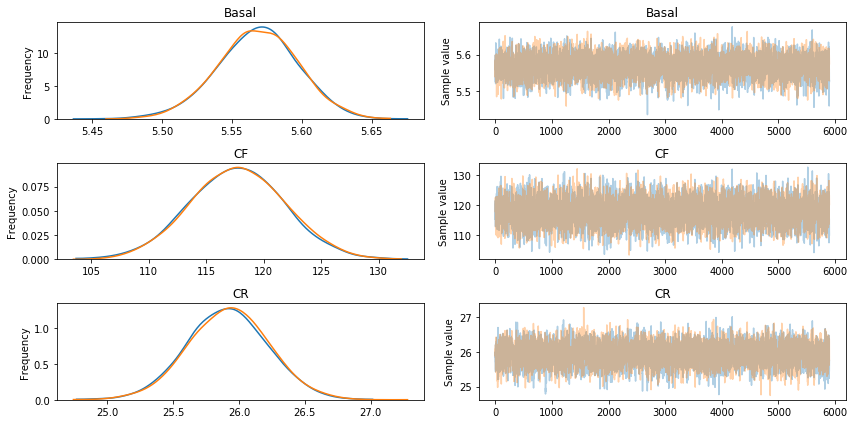

In [39]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7, 7))

pm.traceplot(trace[100:])
plt.tight_layout();